In [15]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

class FactVerificationDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        encoded_input = self.tokenizer.encode_plus(
            item['Claim'],
            item['evidence'],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        label = item['label']
        return {
            'input_ids': encoded_input['input_ids'].squeeze(),
            'attention_mask': encoded_input['attention_mask'].squeeze(),
            'label': torch.tensor(label)
        }

In [ ]:
pip install transformers

In [2]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('textattack/bert-base-uncased-snli', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('textattack/bert-base-uncased-snli')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [3]:
import json

# Step 1: Open the JSON file
with open('/content/train.json', 'r', encoding='utf-8') as file:
    # Step 2: Parse the JSON data
    training_data = json.load(file)

# Step 3: Access the data
print(training_data)

[{'Claim': 'Photo shows Dawn article on Pakistan pilot urinating in F-16 cockpit', 'Most Relevant Sentence': 'The headline of the viral screenshot reads, "Pilot pissing in the cockpit of PAF F-16 said urine increases efficiency of jets told by Allah in his dream', 'label': 0}, {'Claim': 'Muslims in Pakistan started “Mandir Banao” campaign after a Hindu temple was destroyed recently in a village in Khyber Pakhtunkhwa province.', 'Most Relevant Sentence': 'Netizens claim that Muslims in Pakistan have started the ‘Mandir Banao’ campaign after a Hindu temple was destroyed in Khyber Pakhtunkhwa', 'label': 1}, {'Claim': 'Pakistan Prime Minister Imran Khan has said, If Pakistan develops coronavirus vaccine then they will not give it to India or Israel.', 'Most Relevant Sentence': 'Many social media handles are claiming that Prime Minister of Pakistan, Imran Khan said, "If Pakistan develops a corona vaccine, it will never give it to Israel or India"', 'label': 0}, {'Claim': 'If Pakistan develo

In [4]:
import json

# Step 1: Open the JSON file
with open('/content/test - Copy.json', 'r', encoding='utf-8') as file:
    # Step 2: Parse the JSON data
    testing_data = json.load(file)

# Step 3: Access the data
print(testing_data)

[{'Claim': 'Asif Zardari has announced support for Imran Khan, saying Shehbaz Sharif cannot lead Pakistan', 'evidence': 'Asif Zardari has not announced support for Khan, nor has he said Sharif cannot lead Pakistan', 'label': 0}, {'Claim': 'A video shows a Punjab Police officer “misbehaving” and “insulting” an older woman amid a recent crackdown by authorities following protests across Pakistan against the 9 May arrest of Imran Khan.', 'evidence': 'The video is not recent, nor does it have anything to do with the May 2023 crackdown by Punjab Police and they were not misbehaving and insulting an older women. ', 'label': 0}, {'Claim': "Video shows Akshay Kumar condemning Imran Khan's arrest", 'evidence': 'We found that the viral clip has been digitally altered by adding Kumar condemning the arrest of imran Khan as Akshay kumar was not condemn the arrest of imran khan', 'label': 0}, {'Claim': 'Former prime minister and Pakistan Tehreek-e-Insaf (PTI) chief Imran Khan has died.', 'evidence':

In [9]:
dataset = FactVerificationDataset(training_data)

In [10]:
# Step 4: Model architecture and fine-tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Train the model
optimizer = AdamW(model.parameters(), lr=2e-5)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)# Step 4: Model architecture and fine-tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Train the model
optimizer = AdamW(model.parameters(), lr=2e-5)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [11]:
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss}")


Epoch 1/2 - Average Loss: 0.42380457522321335
Epoch 2/2 - Average Loss: 0.13937321228375266


In [12]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
evaluation_dataset = FactVerificationDataset(testing_data)  # Replace eval_data with your evaluation dataset
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=16, shuffle=False)

In [18]:

correct_predictions = 0
total_predictions = 0

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

Accuracy: 0.8400852878464818


In [19]:
correct_predictions = 0
total_predictions = 0
predicted_labels_list = []  # List to store predicted labels
original_labels_list = []   # List to store original labels

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

    # Append predicted and original labels to their respective lists
    predicted_labels_list.extend(predicted_labels.cpu().numpy())
    original_labels_list.extend(labels.cpu().numpy())

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

# Now you can work with predicted_labels_list and original_labels_list outside the loop


Accuracy: 0.8400852878464818


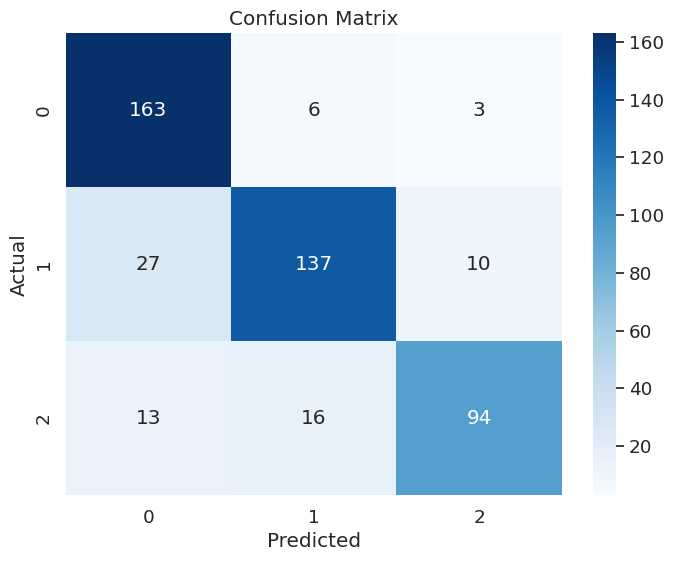

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming correct_predictions and predicted_labels are your data
correct_predictions = [0, 1, 2, 0, 1, 2, 0, 1, 2]
predicted_labels = [0, 1, 2, 1, 0, 1, 2, 0, 2]

# Get unique labels from the data
labels = [0,1,2]

# Create the confusion matrix
conf_matrix = confusion_matrix(original_labels_list, predicted_labels_list, labels=labels)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
true_positives = 0
false_positives = 0
false_negatives = 0

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

        # Check if 'logits' key exists in outputs
        if 'logits' in outputs:
            logits = outputs.logits
        else:
            # If 'logits' key is not present, try to access from 'last_hidden_state'
            logits = outputs.last_hidden_state[:, 0, :]  # Assuming XLM-RoBERTa, take the [CLS] token representation

        predicted_labels = torch.argmax(logits, dim=1)

    true_positives += ((predicted_labels == 1) & (labels == 1)).sum().item()
    false_positives += ((predicted_labels == 1) & (labels == 0)).sum().item()
    false_negatives += ((predicted_labels == 0) & (labels == 1)).sum().item()

precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.9580419580412881
Recall: 0.8353658536580273
F1 Score: 0.8925081432721281


In [23]:
from sklearn.metrics import classification_report

# Assuming original_labels_list and predicted_labels_list are your data


# Get unique labels from the data
labels = sorted(set(original_labels_list + predicted_labels_list))

# Compute the classification report
class_report = classification_report(original_labels_list, predicted_labels_list, labels=labels)

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       172
           1       0.86      0.79      0.82       174
           2       0.88      0.76      0.82       123

    accuracy                           0.84       469
   macro avg       0.85      0.83      0.84       469
weighted avg       0.84      0.84      0.84       469



In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score



# Get unique labels from the data
labels = sorted(set(original_labels_list + predicted_labels_list))

# Compute precision, recall, and F1 score for each class
precision_per_class = precision_score(original_labels_list, predicted_labels_list, labels=labels, average=None)
recall_per_class = recall_score(original_labels_list, predicted_labels_list, labels=labels, average=None)
f1_per_class = f1_score(original_labels_list, predicted_labels_list, labels=labels, average=None)

# Compute micro and macro averages
micro_precision = precision_score(original_labels_list, predicted_labels_list, average='micro')
micro_recall = recall_score(original_labels_list, predicted_labels_list, average='micro')
micro_f1 = f1_score(original_labels_list, predicted_labels_list, average='micro')

macro_precision = precision_score(original_labels_list, predicted_labels_list, average='macro')
macro_recall = recall_score(original_labels_list, predicted_labels_list, average='macro')
macro_f1 = f1_score(original_labels_list, predicted_labels_list, average='macro')

# Print or use the results as needed


In [25]:
print(micro_f1)

0.8400852878464818


In [26]:
print(macro_f1)

0.836515820167994
